In [1]:
#Import packages
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import openpyxl

In [2]:
from functions import *

In [3]:
# Separate the data into 2 groups: (1) aC and (2) nC
xl = pd.ExcelFile('sujetos_time_series_codes.xlsx')
df = xl.parse('datos_demograficos_sanos_schaef')

In [4]:
# Quiero sacar los indices de los sujetos aC y nC
aC_index = df[df['CONDICIÓN']=='aC']
nC_index = df[df['CONDICIÓN']=='nC']

In [8]:
# Directory containing the data
results_dir = 'C:/Users/ifiri/Documents/PROYECTOS/2024_claudia_alzheimer/results'
data_dir = 'C:/Users/ifiri/Documents/PROYECTOS/2024_claudia_alzheimer/precuneus_nets'
os.chdir(data_dir)

# Load the time series data
ts_data, ts_data_struc, struc_names = process_data(data_dir)

# Select the data for the aC group using the indices
ts_aC_data = ts_data[aC_index.index]

# Select the data for the nC group using the indices
ts_nC_data = ts_data[nC_index.index]

In [34]:
# SELECT THE GROUP TO ANALYZE
ts_data = ts_nC_data
group = 'nC'

In [36]:
# Window the data and compute the correlation matrices
structure_names = struc_names.to_list()
delta = 8 #number of time points on each window. LB^(-1) = delta * TR (2.2s)
corr_matrices = split_into_windows_and_compute_correlation(ts_data, delta)
print(corr_matrices.shape)  # Debería ser (62, 62, 57, 33)

(62, 62, 25, 33)


Example plots and data exploration analysis

In [11]:
# Access a specific value
subject_id = 'Subject001'
timepoint = 1
structure = 'atlas.Precuneous'

specific_value = ts_data_struc.sel(subject=subject_id, timepoint=timepoint, struc=structure).item()
print(f"The value for {subject_id}, timepoint {timepoint}, structure '{structure}' is {specific_value}.")

The value for Subject001, timepoint 1, structure 'atlas.Precuneous' is -0.0156951029554407.


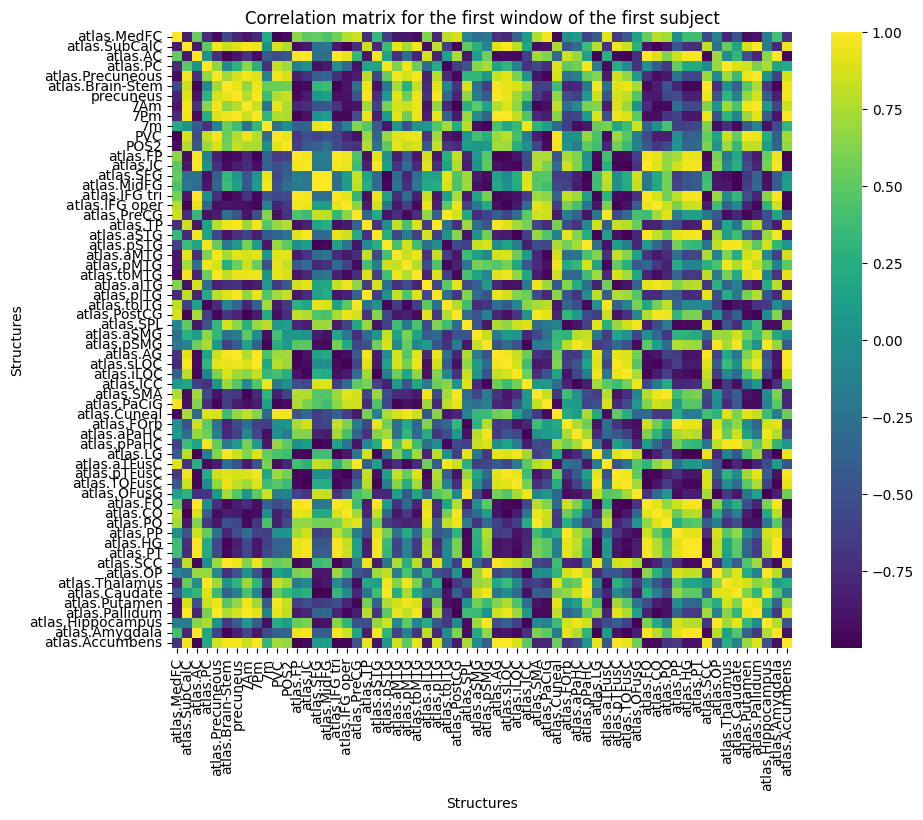

In [12]:
# plot a heatmap (sns) of a correlation matrix (e.g. the first one) from corr_df and add the x and y labels of the structure_names

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrices[:, :, 0, 0], xticklabels=structure_names, yticklabels=structure_names, cmap='viridis')
plt.xlabel('Structures')
plt.ylabel('Structures')
plt.title('Correlation matrix for the first window of the first subject')
plt.show()


IndexError: index 33 is out of bounds for axis 3 with size 33

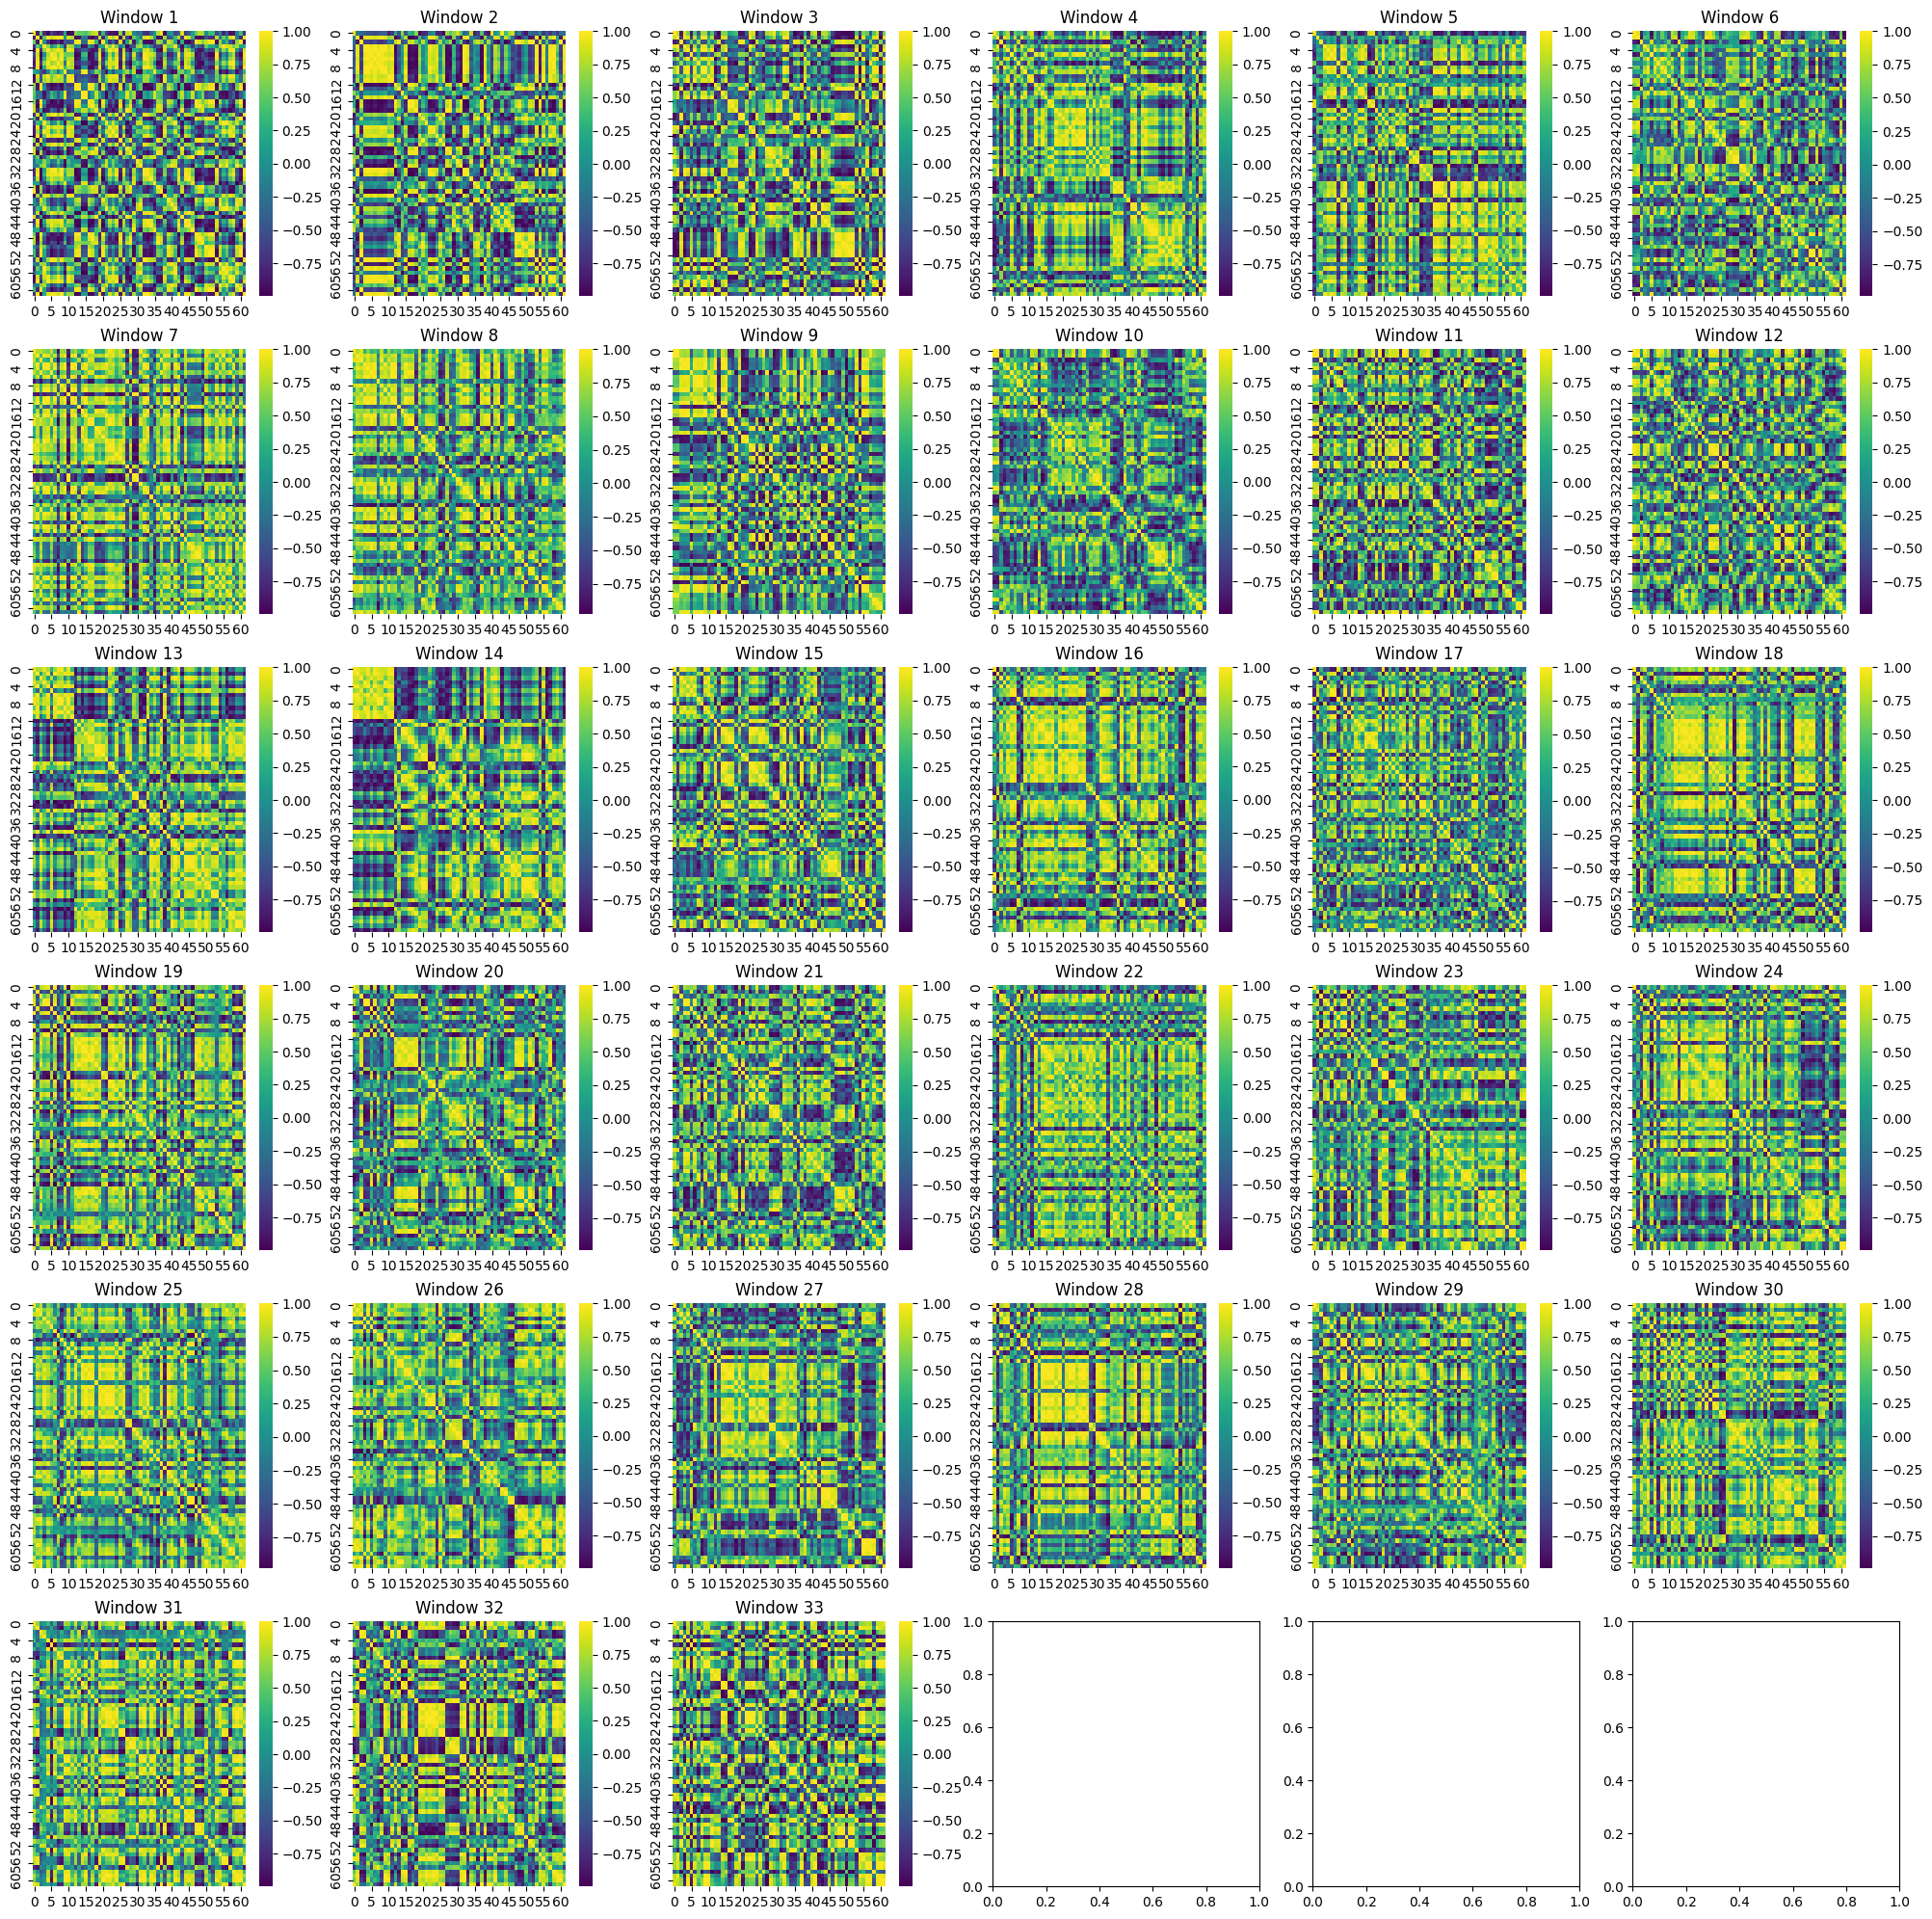

In [13]:
# Make a panel of figures with the correlation matrices for the first subject and all windows (33 windows) a grid of 6x6 figures

fig, axs = plt.subplots(6, 6, figsize=(25, 25))
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(corr_matrices[:, :, 0, i], cmap='viridis', ax=ax)
    ax.set_title(f'Window {i+1}')



In [14]:
# Access a specific structure
structure = 'atlas.Precuneous'

# Select the data for the specified structure
specific_structure_data = ts_data_struc.sel(struc=structure)
print(f"Data for structure '{structure}':\n", specific_structure_data)

Data for structure 'atlas.Precuneous':
 <xarray.DataArray (subject: 57, timepoint: 264)> Size: 120kB
array([[ 0.01391305, -0.0156951 , -0.03661022, ...,  0.05642792,
        -0.00223421, -0.06272297],
       [ 0.088349  ,  0.02851485, -0.04775371, ..., -0.01664198,
         0.01605906,  0.03971476],
       [-0.04054683, -0.01357598,  0.01996939, ...,  0.08903074,
         0.01164096, -0.08437934],
       ...,
       [-0.09449431, -0.00627745,  0.08604377, ..., -0.00842487,
         0.0106624 ,  0.02360613],
       [-0.03455009, -0.02598357,  0.00797527, ..., -0.00405186,
         0.01776135,  0.01865796],
       [ 0.12555343,  0.00542055, -0.11303777, ..., -0.05880973,
         0.0054838 ,  0.06831283]])
Coordinates:
  * subject    (subject) <U10 2kB 'Subject001' 'Subject002' ... 'Subject057'
  * timepoint  (timepoint) int32 1kB 0 1 2 3 4 5 6 ... 258 259 260 261 262 263
    struc      <U16 64B 'atlas.Precuneous'


INTER-PRECUNEUS ANALYSIS: 6 ANALYSIS IN TOTAL
(1) precuneus (total) with the rest
(2-6) 7Am, 7Pm, 7m, PVC and POS2 with the rest 

In [47]:
# Fix the structure
structure = 'POS2'

In [48]:
# We will fix one structure and perfom the analysis
structure_index = structure_names.index(structure)

# Seleccionar todas las estructuras excepto la fijada
remaining_indices = [i for i in range(len(structure_names)) if i != structure_index]

# Seleccionar los datos correspondientes a la fila de la estructura fijada y las columnas restantes
corr_matrices_structure_rows = corr_matrices[remaining_indices,:, :, :]
corr_matrices_structure_col = corr_matrices_structure_rows[:,structure_index, :, :]
print(corr_matrices_structure_col[:,2,20]) # Debería ser un vector de 62 elementos. El elemento 6 (precuneus) debería tener valor de corr=1. La correlacion de una estructura consigo misma (6,6) es 1.

# I want to compute the euclidean distance between all pairs of 33 windows so that i obtain a 33x33 matrix for each subject. 
# I will have 57 subjects, so the final matrix will be 33x33x57.

norm_distances = compute_norm_distances(corr_matrices_structure_col)
print(norm_distances.shape)  # Debería ser (33, 33, 57)

# Flatten each subject distance matrix to obtain a vector per subject

flattened_distances = flatten_distance_matrices(norm_distances)
print(flattened_distances.shape)  # Debería ser (57, 1089)

# Mean distance per subject
mean_distances = np.mean(flattened_distances, axis=1)

# Save the mean distances to a CSV file in the main folder and include fixed structure name in the filename
filename = f'{group}_inter_analysis_mean_distances_{structure}.csv'
np.savetxt(os.path.join(results_dir,filename), mean_distances, delimiter=',')
print(f"Mean distances saved to '{filename}'.")

[-0.96163387  0.64100916  0.68495848  0.98976598  0.95778498  0.63826916
  0.95533128  0.51583978  0.51143588  0.98604436  0.70717404 -0.65039911
 -0.10053523  0.43809118  0.85130947  0.92920463  0.96825027 -0.4265998
  0.68486118 -0.95529395 -0.91847886  0.77148865 -0.49307773 -0.36124769
  0.26557274  0.71400939  0.42222243 -0.47859111 -0.13062635  0.40696298
  0.74329904  0.97214907  0.76369391  0.72777031  0.68079727 -0.23728847
  0.86800751  0.9492261   0.36520621 -0.11894834  0.31260802  0.46167689
  0.68847641  0.78367837 -0.62014456  0.64272658  0.56746878 -0.78333515
 -0.73097715 -0.6669902  -0.43902455 -0.73884212  0.52183878  0.35448595
 -0.59173112 -0.66174521 -0.82899014  0.33117771  0.48211914  0.44424523
  0.01350168]
(33, 33, 25)
(25, 1089)
Mean distances saved to 'nC_inter_analysis_mean_distances_POS2.csv'.


INTRA-PRECUNEUS ANALYSIS: 1 IN TOTAL.
7Am, 7Pm, 7m, PCV and POS2 strucs between them

In [49]:
# Fix the 5 structures and find the index of each one
strucs =  '7Am', '7Pm', '7m', 'PVC', 'POS2'

In [50]:
# We will fix one structure and perfom the analysis
structure_indices = [structure_names.index(s) for s in strucs]

# Select the data for the specified structure. The final matrix should be 5x5x57x33
corr_matrices_structure_row = corr_matrices[structure_indices, :, :, :]
corr_matrices_structure_col = corr_matrices_structure_row[:, structure_indices, :, :]
print(corr_matrices_structure_col.shape)  # Debe ser: (5,5,57,33)

# Flatten the intra-structure matrices to compute the norm distance between vectors and no between matrices
intra_size = corr_matrices_structure_col.shape[0]
subjects = corr_matrices_structure_col.shape[2]
windows = corr_matrices_structure_col.shape[3]
corr_matrices_structure_flat = corr_matrices_structure_col.reshape(intra_size*intra_size, subjects, windows)

# I want to compute the euclidean distance between all pairs of 33 windows so that i obtain a 33x33 matrix for each subject. 
# I will have 57 subjects, so the final matrix will be 33x33x57.

norm_distances = compute_norm_distances(corr_matrices_structure_flat)
print(norm_distances.shape)  # Debería ser (33, 33, 57)

# Flatten each subject distance matrix to obtain a vector per subject

flattened_distances = flatten_distance_matrices(norm_distances)
print(flattened_distances.shape)  # Debería ser (57, 1089)

# Mean distance per subject
mean_distances = np.mean(flattened_distances, axis=1)

# Save the mean distances to a CSV file in the main folder and include fixed structure name in the filename
filename = f'{group}_intra_analysis_mean_distances_5precuneus.csv'
np.savetxt(os.path.join(results_dir,filename), mean_distances, delimiter=',')
print(f"Mean distances saved to '{filename}'.")

(5, 5, 25, 33)
(33, 33, 25)
(25, 1089)
Mean distances saved to 'nC_intra_analysis_mean_distances_5precuneus.csv'.
